In [127]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

import pandas as pd
from pandas.tools.plotting import scatter_matrix

import matplotlib.image as mpimg

In [128]:
def centerize( df ):
    mean = np.mean( df, axis = 0 )
    centered = df - mean 
    return (centered, mean)

class PCA:
    def __init__(self, X):
        # X's shape (items,dimensions)
        (centered, self.means) = centerize(X)
        cov = np.cov( centered.T )

        (eig_values, eig_vectors) = np.linalg.eig(cov)

        eig_idx = np.argsort(-eig_values)
        (self.eig_values, self.eig_vectors) = (eig_values[eig_idx], eig_vectors[:,eig_idx])
        
    def project(self, X):
        # X's shape (items,dimensions)
        X = X - self.means
        return np.dot(X, self.eig_vectors)
    
    def reconstruct(self, X, eig_vectors_idx):
        res = np.dot( X, self.eig_vectors[:, eig_vectors_idx].T )
        res = res.T + self.means.reshape(len(self.means),1)
        return res.T
    

# Q3.1 Preprocessing

In [129]:
dpca2 = pd.read_csv('pca2.csv', sep=",")

In [130]:
dpca2.describe()

,X1,X2
count,500.000000,500.000000
mean,0.951146,1.012466
std,1.656783,1.272475
min,-3.776304,-13.000000
25%,-0.150238,0.441767
50%,0.992120,1.029902
75%,1.997481,1.662033
max,5.964610,13.000000


In [131]:
pca2 = PCA(dpca2)

In [132]:
projectedPCA2 = pca2.project(dpca2)

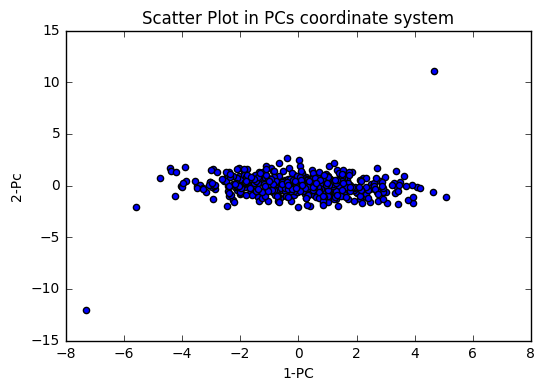

In [133]:
plt.scatter(projectedPCA2[:, 0], projectedPCA2[:, 1])
plt.ylim(-15,15)
plt.xlim(-8,8)
plt.xlabel('1-PC')
plt.ylabel('2-Pc')
plt.title('Scatter Plot in PCs coordinate system')

From the plot above, we observe 2 outliers.

In [134]:
dpca2_adjusted = np.delete(dpca2.values,[16,156],0)
dpca2_adjusted.shape

(498, 2)

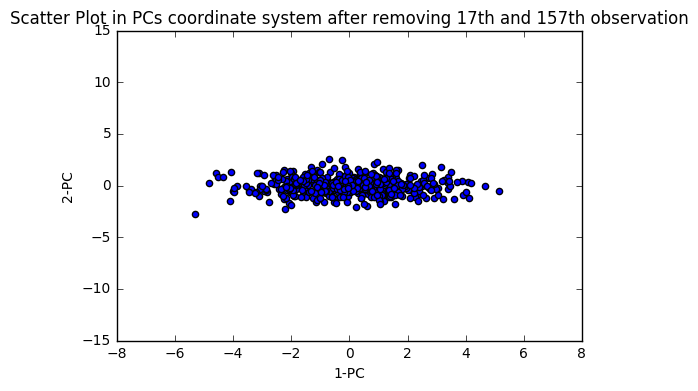

In [135]:
pca2 = PCA(dpca2_adjusted)
projectedPCA2Adjusted = pca2.project(dpca2_adjusted)
plt.scatter(projectedPCA2Adjusted[:, 0], projectedPCA2Adjusted[:, 1])
plt.xlabel('1-PC')
plt.ylabel('2-PC')
plt.ylim(-15,15)
plt.xlim(-8,8)
plt.title('Scatter Plot in PCs coordinate system after removing 17th and 157th observation')

# Q3.2 Whitening

In [136]:
dpca4 = pd.read_csv('pca4.csv', sep=",")

In [137]:
dpca4.describe()

,X1,X2,X3,X4
count,500.000000,500.000000,500.000000,500.000000
mean,0.005812,0.107921,-0.020360,-0.012750
std,1.705942,1.774020,0.817685,0.823096
min,-5.826935,-5.130027,-12.000000,-12.000000
25%,-1.227183,-0.989710,-0.222386,-0.222493
50%,0.000000,0.000000,-0.011047,-0.035263
75%,1.084526,1.361009,0.194231,0.200987
max,4.717990,5.024882,12.000000,12.000000


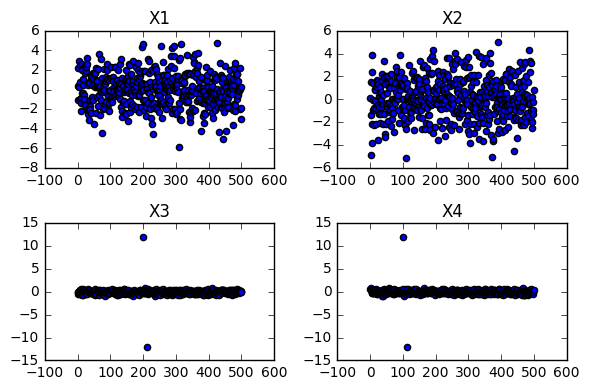

In [138]:
r = range(500)
cols = ['X1','X2','X3','X4']
for i in range(len(cols)): 
    plt.subplot(2,2,i+1)
    plt.scatter(r, dpca4[cols[i]])
    plt.title(cols[i])
plt.tight_layout()

In [164]:
dpc4_filtered = dpca4.loc[ np.logical_and( abs(dpca4.X3) <=  10, abs(dpca4.X4) <= 10 ) ]
len(dpc4_filtered)

496

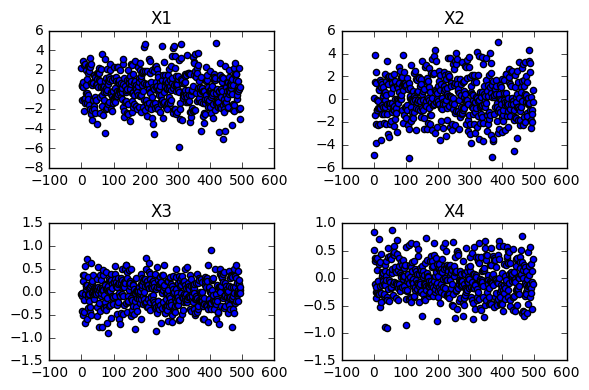

In [171]:
r = range(len(dpc4_filtered))
for i in range(len(cols)): 
    plt.subplot(2,2,i+1)
    plt.scatter(r, dpc4_filtered[cols[i]])
    plt.title(cols[i])
plt.tight_layout()

In [172]:
pca4 = PCA(dpc4_filtered)
pca4.eig_values

array([ 4.16661605,  1.93983139,  0.10130627,  0.09181741])

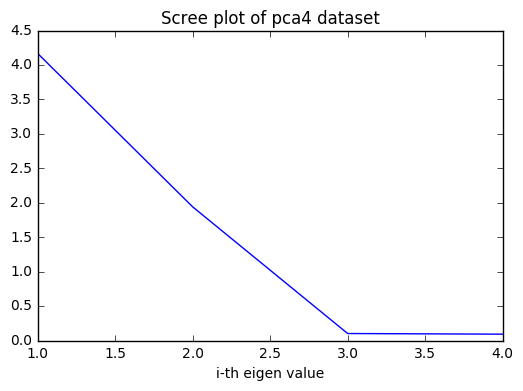

In [173]:
plt.title('Scree plot of pca4 dataset')
plt.plot( range(1,5), pca4.eig_values )
plt.xlabel('i-th eigen value')

From the plot, the first 2 PCs are sufficient to represent the data

In [141]:
def whitening(X):
    (centered, _) = centerize(X)
    pc = PCA(centered)
    A  = np.diag( np.sqrt(pc.eig_values) )
    Z = ( centered @ pc.eig_vectors ) @ A
    return Z

In [169]:
pca4_whitened = whitening(dpc4_filtered)

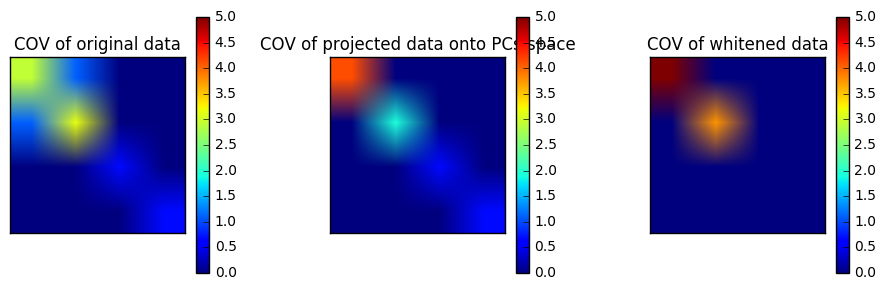

In [170]:
plt.figure(figsize=(9,3))

cov_original = np.cov(dpca4.T)
plt.subplot(1,3,1)
plt.title('COV of original data')
plt.imshow(cov_original, vmin=0, vmax=5)
plt.colorbar()
plt.xticks([])
plt.yticks([])

dpca4_projected = pca4.project(dpca4)
cov_projected = np.cov(dpca4_projected.T)
plt.subplot(1,3,2)
plt.title('COV of projected data onto PCs space')
plt.imshow(cov_projected, vmin=0, vmax=5)
plt.colorbar()
plt.xticks([])
plt.yticks([])

cov_whitened = np.cov(pca4_whitened.T)
plt.subplot(1,3,3)
plt.title('COV of whitened data')
plt.imshow(cov_whitened, vmin=0, vmax=5)
plt.colorbar()
plt.xticks([])
plt.yticks([])

plt.tight_layout()

# Q3.3 Derive Oja's rule

Denote $T(f)$ a Taylor series of a function $f$. As a result, Taylor series of $w_i(t+1)$ is

\begin{align*}
T\big(w_i(t+1)\big) \bigg |_{\epsilon=0}  = w_i(t+1) \bigg |_{\epsilon=0} + (\epsilon-0)\frac{\partial}{\partial \epsilon } w_i(t+1) \bigg |_{\epsilon=0}
\end{align*}

For $w_i(t+1) \bigg |_{\epsilon=0}$

\begin{align*}
w_i(t+1) \bigg |_{\epsilon=0} &= \frac{w_i(t)}{\sqrt{\sum_{j=1}^{N}w_j(t)}} \\
&= w_i(t) \hspace{2cm}; 
\end{align*}
Due to the fact that $\sqrt{\sum_{j=1}^{N}w_j(t)} = 1$, we have

\begin{align*}
w_i(t+1) \bigg |_{\epsilon=0} &= w_i(t) \hspace{2cm}
\end{align*}

For $\epsilon\frac{\partial}{\partial \epsilon } w_i(t+1) \bigg |_{\epsilon=0}$, we first denote 

\begin{align*}
A = \sqrt{\sum_{j=1}^{N}w_j(t)+\epsilon y(t)x_j(t)}
\end{align*}

Then,

\begin{align*}
\frac{\partial}{\partial \epsilon } w_i(t+1)  &= \frac{y(t)x_i(t)}{A} - \frac{\big (w_i(t) + \epsilon y(t)x_i(t) \big) y(t)\sum_{j=1}^{N} w_j(t) x_j(t) + \epsilon y(t) x_j^2(t)}{A^3}  
\end{align*}

Using knowledge that

\begin{align*}
A \big |_{\epsilon=0} &= \sqrt{\sum_{j=1}^{N}w_j(t)}\\
&= 1
\end{align*}

Thus,

\begin{align*}
\frac{\partial}{\partial \epsilon } w_i(t+1) \Bigg |_{\epsilon=0}   &=  y(t)x_i(t) - w_i(t) y(t)\sum_{j=1}^{N} w_j(t) x_j(t) \\
&= y(t)x_i(t) - w_i(t) y^2(t)
\end{align*}

Therefore

\begin{align*}
T\big(w_i(t+1)\big) \bigg |_{\epsilon=0} = w_i(t) + \epsilon y(t) \big( x_i(t) - y(t) w_i(t) \big) 
\end{align*}


# Q3.4 Oja’s Rule: Application

In [144]:
dpcaOnline = pd.read_csv('data-onlinePCA.txt', sep=",", index_col=0)

In [145]:
dpcaOnline.describe()

,V1,V2
count,2000.000000,2000.000000
mean,0.016554,-0.013381
std,0.767851,0.669151
min,-2.925993,-2.946526
25%,-0.399228,-0.377488
50%,0.015803,-0.014508
75%,0.446225,0.349416
max,3.037307,2.895316


In [146]:
totalData = len(dpcaOnline)
buckets = int(totalData / 10)
print(totalData, buckets)

2000 200


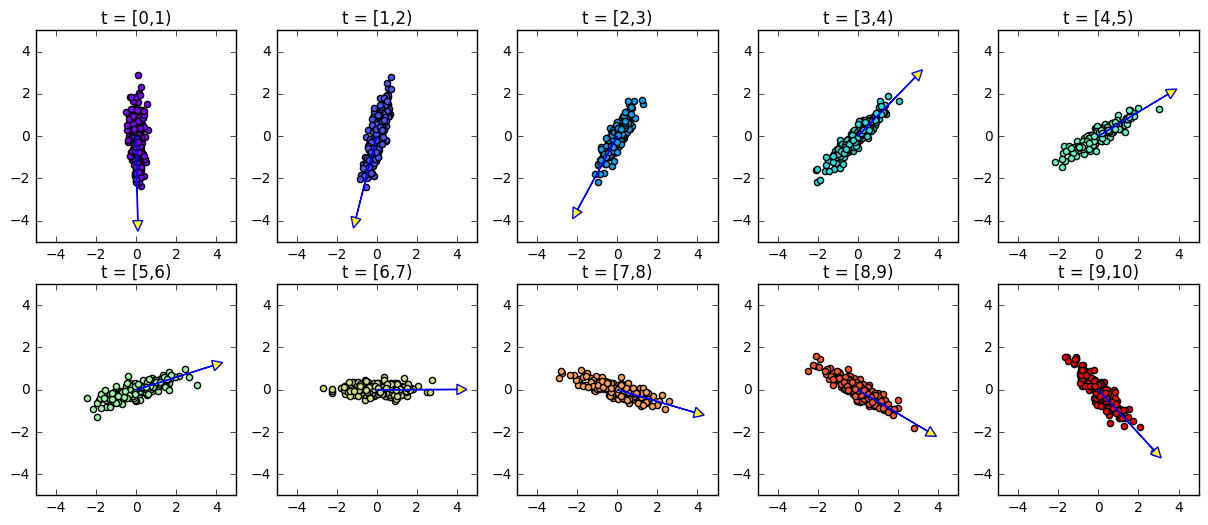

In [147]:
import matplotlib.cm as cm


plt.figure(figsize=(15,6))
colors = cm.rainbow(np.linspace(0,1,10))

for i,c in zip(range(10), colors):
    plt.subplot(2,5,i+1)
    r = range(i*buckets, (i+1)*buckets)
    data = dpcaOnline.values[r]
    pca = PCA(data)
    plt.scatter( dpcaOnline.values[r, 0], dpcaOnline.values[r,1], c=c )
    first_eig_vector = pca.eig_vectors[:, 0] * 4
    plt.arrow(0, 0, first_eig_vector[0], first_eig_vector[1], head_width=0.5, head_length=0.5, fc='yellow', ec='blue')
    plt.title('t = [%d,%d)' % (i,i+1))
    plt.xlim(-5,5)
    plt.ylim(-5,5)

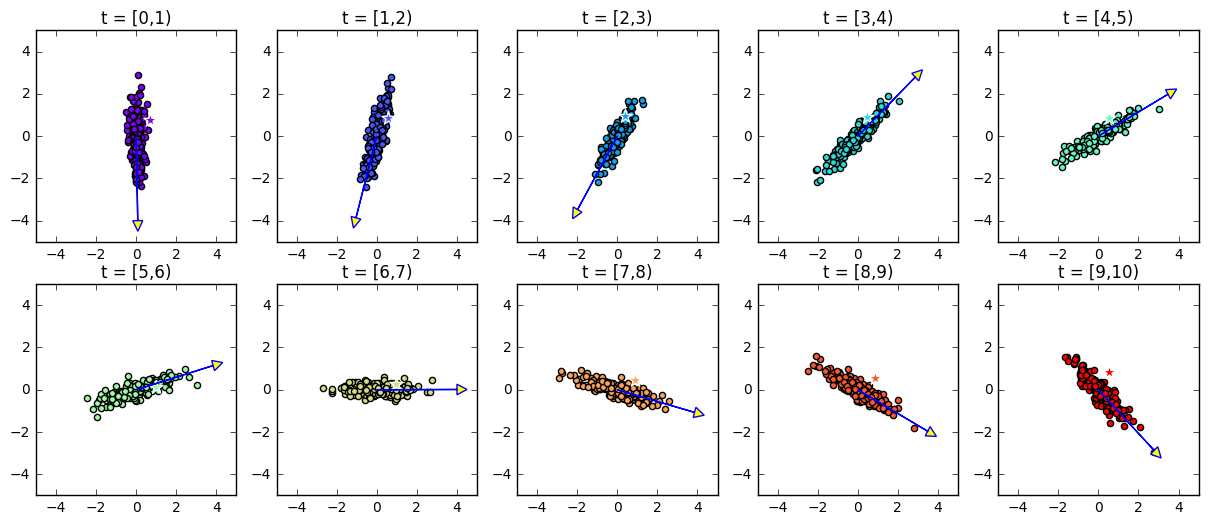

In [148]:
def hebbian( learning_rate=0.002 ):
    plt.figure(figsize=(15,6))

    for i, c in zip(range(10),colors):
        w = np.random.rand(2)

        plt.subplot(2,5,i+1)
        r = range(i*buckets, (i+1)*buckets)
        data = dpcaOnline.values[r]
        pca = PCA(data)
        plt.scatter( dpcaOnline.values[r, 0], dpcaOnline.values[r,1], c=c )
        first_eig_vector = pca.eig_vectors[:, 0] * 4
        plt.arrow(0, 0, first_eig_vector[0], first_eig_vector[1], head_width=0.5, head_length=0.5, fc='yellow', ec='blue')
        plt.title('t = [%d,%d)' % (i,i+1))
        plt.xlim(-5,5)
        plt.ylim(-5,5)

        for j in range(buckets):
            idx = i*buckets+j
            x = dpcaOnline.values[idx,:]
            y = x @ w
            w_raw = w + learning_rate * y * x.T
            w = w_raw / np.linalg.norm(w_raw)
        plt.scatter(w[0], w[1], marker="*", color=c, s=100, edgecolor='white')
hebbian(0.002)

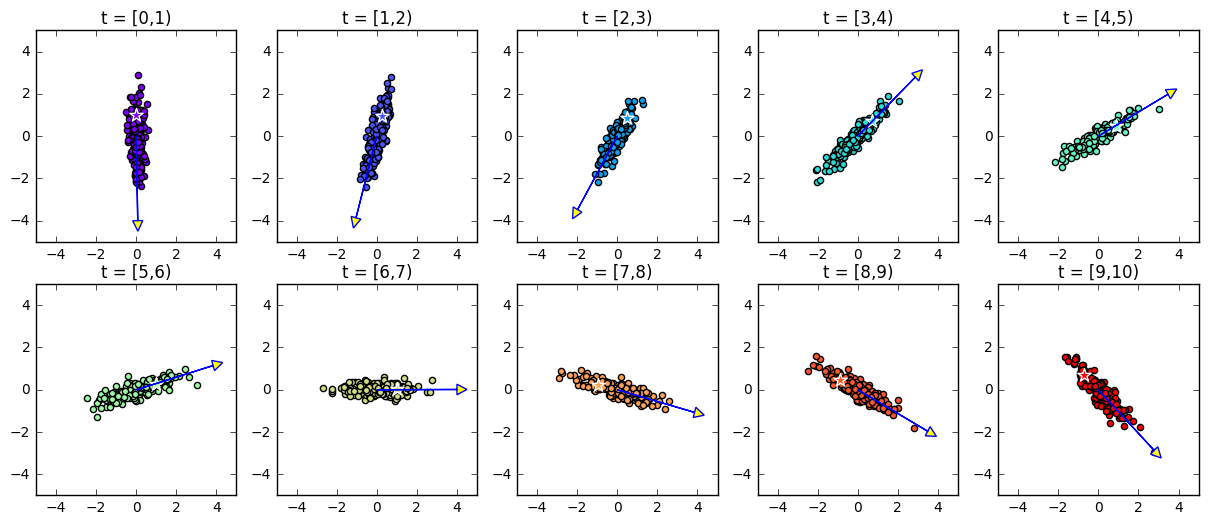

In [149]:
hebbian(0.04)

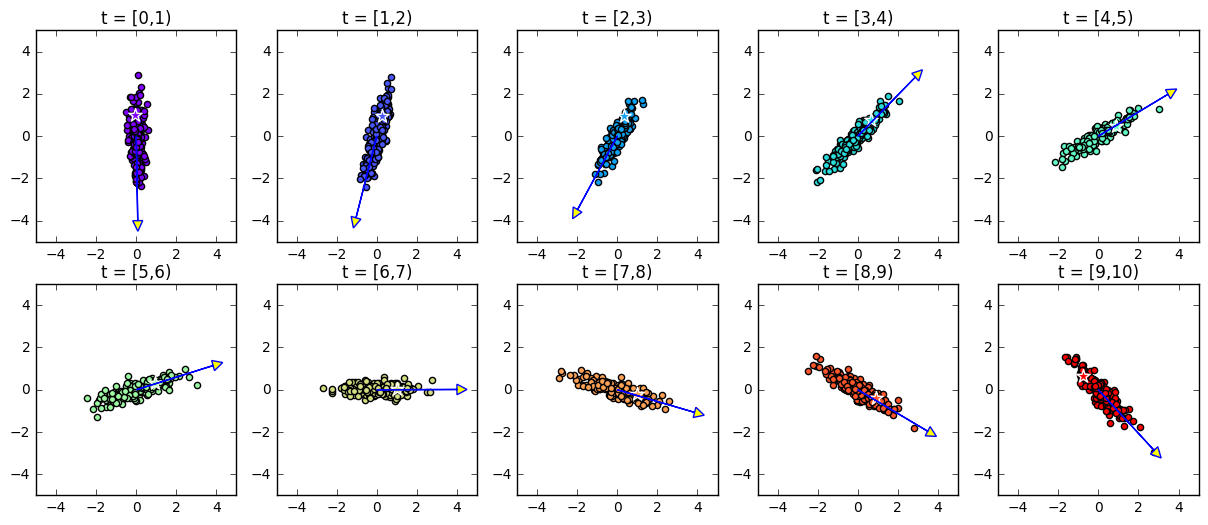

In [150]:
hebbian(0.45)

### Interpret the results